In [24]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/corrected/test_corrected.csv
/kaggle/input/corrected/train_corrected.csv
/kaggle/input/data-collinearity-removed/train_removed_collinear.csv
/kaggle/input/data-collinearity-removed/test_removed_collinear.csv
/kaggle/input/data-ratios/test_with_ratios.csv
/kaggle/input/data-ratios/train_with_ratios.csv


## Importing relevant packages

In [2]:
# pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# featuretools for automated feature engineering
import featuretools as ft

# matplotlit and seaborn for visualizations
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 22
import seaborn as sns

# Suppress warnings from pandas
import warnings
warnings.filterwarnings('ignore')

# modeling 
import lightgbm as lgb

# utilities
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder

# memory management
import gc

/opt/conda/lib/python3.7/site-packages/woodwork/__init__.py:23: FutureWarning: Woodwork may not support Python 3.7 in next non-bugfix release.
  "Woodwork may not support Python 3.7 in next non-bugfix release.", FutureWarning
/opt/conda/lib/python3.7/site-packages/featuretools/__init__.py:67: FutureWarning: Featuretools may not support Python 3.7 in next non-bugfix release.
  FutureWarning,


## Reading the Data

In [47]:
train = pd.read_csv("/kaggle/input/corrected/train_corrected.csv")
test = pd.read_csv("/kaggle/input/corrected/test_corrected.csv")

## Advanced Feature Engineering

We will be working on the following ratios:
1. Credit 
2. Income 
3. Time
4. Credit to Income
5. Previous to Current Credit
6. Previous to Current Annuity
7. Installment payments to Annuity

We will also create some features based on external sources.


## Credit Ratios

In [48]:
train['CREDIT_TO_ANNUITY_RATIO'] = train['AMT_CREDIT'] / train['AMT_ANNUITY']
train['CREDIT_TO_GOODS_RATIO'] = train['AMT_CREDIT'] / train['AMT_GOODS_PRICE']

In [49]:
test['CREDIT_TO_ANNUITY_RATIO'] = test['AMT_CREDIT'] / test['AMT_ANNUITY']
test['CREDIT_TO_GOODS_RATIO'] = test['AMT_CREDIT'] / test['AMT_GOODS_PRICE']

## Income Ratios

In [50]:
train['ANNUITY_TO_INCOME_RATIO'] = train['AMT_ANNUITY'] / train['AMT_INCOME_TOTAL']
train['CREDIT_TO_INCOME_RATIO'] = train['AMT_CREDIT'] / train['AMT_INCOME_TOTAL']
train['INCOME_TO_EMPLOYED_RATIO'] = train['AMT_INCOME_TOTAL'] / train['DAYS_EMPLOYED']
train['INCOME_TO_BIRTH_RATIO'] = train['AMT_INCOME_TOTAL'] / train['DAYS_BIRTH']

In [51]:
test['ANNUITY_TO_INCOME_RATIO'] = test['AMT_ANNUITY'] / test['AMT_INCOME_TOTAL']
test['CREDIT_TO_INCOME_RATIO'] = test['AMT_CREDIT'] / test['AMT_INCOME_TOTAL']
test['INCOME_TO_EMPLOYED_RATIO'] = test['AMT_INCOME_TOTAL'] / test['DAYS_EMPLOYED']
test['INCOME_TO_BIRTH_RATIO'] = test['AMT_INCOME_TOTAL'] / test['DAYS_BIRTH']    

## Time Ratios

In [52]:
train['EMPLOYED_TO_BIRTH_RATIO'] = train['DAYS_EMPLOYED'] / train['DAYS_BIRTH']
train['ID_TO_BIRTH_RATIO'] = train['DAYS_ID_PUBLISH'] / train['DAYS_BIRTH']
train['CAR_TO_BIRTH_RATIO'] = train['OWN_CAR_AGE'] / train['DAYS_BIRTH']
train['CAR_TO_EMPLOYED_RATIO'] = train['OWN_CAR_AGE'] / train['DAYS_EMPLOYED']
train['PHONE_TO_BIRTH_RATIO'] = train['DAYS_LAST_PHONE_CHANGE'] / train['DAYS_BIRTH']
train['DAYS_DECISION_MEAN_TO_BIRTH'] = train['previous_DAYS_DECISION_mean'] / train['DAYS_BIRTH']
train['DAYS_CREDIT_MEAN_TO_BIRTH'] = train['bureau_DAYS_CREDIT_mean'] / train['DAYS_BIRTH']
train['DAYS_DECISION_MEAN_TO_EMPLOYED'] = train['previous_DAYS_DECISION_mean'] / train['DAYS_EMPLOYED']
train['DAYS_CREDIT_MEAN_TO_EMPLOYED'] = train['bureau_DAYS_CREDIT_mean'] / train['DAYS_EMPLOYED']

In [53]:
test['EMPLOYED_TO_BIRTH_RATIO'] = test['DAYS_EMPLOYED'] / test['DAYS_BIRTH']
test['ID_TO_BIRTH_RATIO'] = test['DAYS_ID_PUBLISH'] / test['DAYS_BIRTH']
test['CAR_TO_BIRTH_RATIO'] = test['OWN_CAR_AGE'] / test['DAYS_BIRTH']
test['CAR_TO_EMPLOYED_RATIO'] = test['OWN_CAR_AGE'] / test['DAYS_EMPLOYED']
test['PHONE_TO_BIRTH_RATIO'] = test['DAYS_LAST_PHONE_CHANGE'] / test['DAYS_BIRTH']
test['DAYS_DECISION_MEAN_TO_BIRTH'] = test['previous_DAYS_DECISION_mean'] / test['DAYS_BIRTH']
test['DAYS_CREDIT_MEAN_TO_BIRTH'] = test['bureau_DAYS_CREDIT_mean'] / test['DAYS_BIRTH']
test['DAYS_DECISION_MEAN_TO_EMPLOYED'] = test['previous_DAYS_DECISION_mean'] / test['DAYS_EMPLOYED']
test['DAYS_CREDIT_MEAN_TO_EMPLOYED'] = test['bureau_DAYS_CREDIT_mean'] / test['DAYS_EMPLOYED']

## Credit to Income Ratios

In [54]:
train['BUREAU_INCOME_CREDIT_RATIO'] = train['bureau_AMT_CREDIT_SUM_mean'] / train['AMT_INCOME_TOTAL']
train['BUREAU_ACTIVE_CREDIT_TO_INCOME_RATIO'] = train['bureau_AMT_CREDIT_SUM_sum'] / train['AMT_INCOME_TOTAL']

In [55]:
test['BUREAU_INCOME_CREDIT_RATIO'] = test['bureau_AMT_CREDIT_SUM_mean'] / test['AMT_INCOME_TOTAL']
test['BUREAU_ACTIVE_CREDIT_TO_INCOME_RATIO'] = test['bureau_AMT_CREDIT_SUM_sum'] / test['AMT_INCOME_TOTAL']

## Previous to Current Credit Ratios 

In [56]:
train['CURRENT_TO_APPROVED_CREDIT_MIN_RATIO'] = train['previous_AMT_CREDIT_min'] / train['AMT_CREDIT']
train['CURRENT_TO_APPROVED_CREDIT_MAX_RATIO'] = train['previous_AMT_CREDIT_max'] / train['AMT_CREDIT']
train['CURRENT_TO_APPROVED_CREDIT_MEAN_RATIO'] = train['previous_AMT_CREDIT_mean'] / train['AMT_CREDIT']

In [57]:
test['CURRENT_TO_APPROVED_CREDIT_MIN_RATIO'] = test['previous_AMT_CREDIT_min'] / test['AMT_CREDIT']
test['CURRENT_TO_APPROVED_CREDIT_MAX_RATIO'] = test['previous_AMT_CREDIT_max'] / test['AMT_CREDIT']
test['CURRENT_TO_APPROVED_CREDIT_MEAN_RATIO'] = test['previous_AMT_CREDIT_mean'] / test['AMT_CREDIT']

## Previous to Current Annuity Ratios

In [58]:
train['CURRENT_TO_APPROVED_ANNUITY_MAX_RATIO'] = train['previous_AMT_ANNUITY_max'] / train['AMT_ANNUITY']
train['CURRENT_TO_APPROVED_ANNUITY_MEAN_RATIO'] = train['previous_AMT_ANNUITY_mean'] / train['AMT_ANNUITY']

In [59]:
test['CURRENT_TO_APPROVED_ANNUITY_MAX_RATIO'] = test['previous_AMT_ANNUITY_max'] / test['AMT_ANNUITY']
test['CURRENT_TO_APPROVED_ANNUITY_MEAN_RATIO'] = test['previous_AMT_ANNUITY_mean'] / test['AMT_ANNUITY']

## Installment Payment to Annuity Ratios

In [ ]:
train['PAYMENT_MIN_TO_ANNUITY_RATIO'] = train['client_installments_AMT_PAYMENT_min_mean'] / train['AMT_ANNUITY']
train['PAYMENT_MAX_TO_ANNUITY_RATIO'] = train['client_installments_AMT_PAYMENT_max_mean'] / train['AMT_ANNUITY']
train['PAYMENT_MEAN_TO_ANNUITY_RATIO'] = train['client_installments_AMT_PAYMENT_mean_mean'] / train['AMT_ANNUITY']

In [ ]:
test['PAYMENT_MIN_TO_ANNUITY_RATIO'] = test['client_installments_AMT_PAYMENT_min_mean'] / test['AMT_ANNUITY']
test['PAYMENT_MAX_TO_ANNUITY_RATIO'] = test['client_installments_AMT_PAYMENT_max_mean'] / test['AMT_ANNUITY']
test['PAYMENT_MEAN_TO_ANNUITY_RATIO'] = test['client_installments_AMT_PAYMENT_mean_mean'] / test['AMT_ANNUITY']

## New Features Based on External Sources

In [60]:
train['EXT_SOURCES_PROD'] = train['EXT_SOURCE_1'] * train['EXT_SOURCE_2'] * train['EXT_SOURCE_3']
train['EXT_SOURCES_WEIGHTED'] = train.EXT_SOURCE_1 * 2 + train.EXT_SOURCE_2 * 1 + train.EXT_SOURCE_3 * 3

In [61]:
test['EXT_SOURCES_PROD'] = test['EXT_SOURCE_1'] * test['EXT_SOURCE_2'] * test['EXT_SOURCE_3']
test['EXT_SOURCES_WEIGHTED'] = test.EXT_SOURCE_1 * 2 + test.EXT_SOURCE_2 * 1 + test.EXT_SOURCE_3 * 3

## Other Ratios

In [62]:
train['LOAN_INCOME_RATIO'] = train['AMT_CREDIT'] / train['AMT_INCOME_TOTAL']
train['INCOME_PER_FAM'] = train['AMT_INCOME_TOTAL'] / train['CNT_FAM_MEMBERS']
train['CHILDREN_RATIO'] = train['CNT_CHILDREN'] / train['CNT_FAM_MEMBERS']
train['LIMITED_USED'] = train['client_credit_AMT_BALANCE_mean_mean'] / train['client_credit_AMT_CREDIT_LIMIT_ACTUAL_mean_mean']
train['CREDIT_CARD_CURRENT_PAYMENT'] = train['client_credit_AMT_PAYMENT_CURRENT_mean_mean'] / train['client_credit_AMT_INST_MIN_REGULARITY_mean_mean']
train['LATE_PAYMENT'] = train['client_credit_SK_DPD_mean_mean'].apply(lambda x: 1 if x > 0 else 0)
train['OVERPAID_AMT'] = train['client_installments_AMT_PAYMENT_mean_mean'] / train['client_installments_AMT_INSTALMENT_mean_mean']
train['DRAWING_LIMIT_RATIO'] = train['client_credit_AMT_DRAWINGS_ATM_CURRENT_mean_mean'] / train['client_credit_AMT_CREDIT_LIMIT_ACTUAL_mean_mean']

In [63]:
test['LOAN_INCOME_RATIO'] = test['AMT_CREDIT'] / test['AMT_INCOME_TOTAL']
test['INCOME_PER_FAM'] = test['AMT_INCOME_TOTAL'] / test['CNT_FAM_MEMBERS']
test['CHILDREN_RATIO'] = test['CNT_CHILDREN'] / test['CNT_FAM_MEMBERS']
test['LIMITED_USED'] = test['client_credit_AMT_BALANCE_mean_mean'] / test['client_credit_AMT_CREDIT_LIMIT_ACTUAL_mean_mean']
test['CREDIT_CARD_CURRENT_PAYMENT'] = test['client_credit_AMT_PAYMENT_CURRENT_mean_mean'] / test['client_credit_AMT_INST_MIN_REGULARITY_mean_mean']
test['LATE_PAYMENT'] = test['client_credit_SK_DPD_mean_mean'].apply(lambda x: 1 if x > 0 else 0)
test['OVERPAID_AMT'] = test['client_installments_AMT_PAYMENT_mean_mean'] / test['client_installments_AMT_INSTALMENT_mean_mean']
test['DRAWING_LIMIT_RATIO'] = test['client_credit_AMT_DRAWINGS_ATM_CURRENT_mean_mean'] / test['client_credit_AMT_CREDIT_LIMIT_ACTUAL_mean_mean']

In [64]:
print('Training shape: ', train.shape)
print('Testing shape: ', test.shape)

Training shape:  (307511, 1498)
Testing shape:  (48744, 1497)


## Dataset Before Removing any Features

In [21]:
train.to_csv('train_with_ratios.csv', index = False)
test.to_csv('test_with_ratios.csv', index = False)

# PART 2: Feature Selection

## Removal of collinear variables

In [65]:
# Threshold for removing correlated variables
threshold = 0.9

# Absolute value correlation matrix
corr_matrix = train.corr().abs()
corr_matrix.head()

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,EXT_SOURCES_PROD,EXT_SOURCES_WEIGHTED,LOAN_INCOME_RATIO,INCOME_PER_FAM,CHILDREN_RATIO,LIMITED_USED,CREDIT_CARD_CURRENT_PAYMENT,LATE_PAYMENT,OVERPAID_AMT,DRAWING_LIMIT_RATIO
SK_ID_CURR,1.000000,0.001129,0.001820,0.000343,0.000433,0.000232,0.000849,0.001500,0.001366,0.000973,...,0.003194,0.003589,0.001726,0.000199,0.000299,0.002357,0.006960,0.002274,0.001113,0.001112
CNT_CHILDREN,0.001129,1.000000,0.012882,0.002145,0.021374,0.001827,0.025573,0.330938,0.239818,0.183395,...,0.106783,0.090967,0.016012,0.231734,0.951270,0.013510,0.009647,0.009019,0.022307,0.003467
AMT_INCOME_TOTAL,0.001820,0.012882,1.000000,0.156870,0.191657,0.159610,0.074796,0.027261,0.064223,0.027805,...,0.015656,0.002517,0.108191,0.861814,0.014411,0.003392,0.001850,0.007329,0.020376,0.022858
AMT_CREDIT,0.000343,0.002145,0.156870,1.000000,0.770138,0.986968,0.099738,0.055436,0.066838,0.009621,...,0.158114,0.144295,0.651097,0.162090,0.005653,0.064700,0.001022,0.035956,0.061503,0.040081
AMT_ANNUITY,0.000433,0.021374,0.191657,0.770138,1.000000,0.775109,0.118429,0.009445,0.104332,0.038514,...,0.127778,0.108028,0.393239,0.205128,0.014384,0.066658,0.001551,0.018607,0.038236,0.038246


In [66]:
# Upper triangle of correlations
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
upper.head()

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,EXT_SOURCES_PROD,EXT_SOURCES_WEIGHTED,LOAN_INCOME_RATIO,INCOME_PER_FAM,CHILDREN_RATIO,LIMITED_USED,CREDIT_CARD_CURRENT_PAYMENT,LATE_PAYMENT,OVERPAID_AMT,DRAWING_LIMIT_RATIO
SK_ID_CURR,NaN,0.001129,0.001820,0.000343,0.000433,0.000232,0.000849,0.001500,0.001366,0.000973,...,0.003194,0.003589,0.001726,0.000199,0.000299,0.002357,0.006960,0.002274,0.001113,0.001112
CNT_CHILDREN,NaN,NaN,0.012882,0.002145,0.021374,0.001827,0.025573,0.330938,0.239818,0.183395,...,0.106783,0.090967,0.016012,0.231734,0.951270,0.013510,0.009647,0.009019,0.022307,0.003467
AMT_INCOME_TOTAL,NaN,NaN,NaN,0.156870,0.191657,0.159610,0.074796,0.027261,0.064223,0.027805,...,0.015656,0.002517,0.108191,0.861814,0.014411,0.003392,0.001850,0.007329,0.020376,0.022858
AMT_CREDIT,NaN,NaN,NaN,NaN,0.770138,0.986968,0.099738,0.055436,0.066838,0.009621,...,0.158114,0.144295,0.651097,0.162090,0.005653,0.064700,0.001022,0.035956,0.061503,0.040081
AMT_ANNUITY,NaN,NaN,NaN,NaN,NaN,0.775109,0.118429,0.009445,0.104332,0.038514,...,0.127778,0.108028,0.393239,0.205128,0.014384,0.066658,0.001551,0.018607,0.038236,0.038246


In [67]:
# Select columns with correlations above threshold
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

print('There are %d columns to remove.' % (len(to_drop)))

There are 610 columns to remove.


In [68]:
train = train.drop(columns = to_drop)
test = test.drop(columns = to_drop)

print('Training shape: ', train.shape)
print('Testing shape: ', test.shape)

Training shape:  (307511, 888)
Testing shape:  (48744, 887)


In [ ]:
train.to_csv('train_removed_collinear.csv', index = False)
test.to_csv('test_removed_collinear.csv', index = False)

## Feature selection through feature importances.

In [3]:
train = pd.read_csv("/kaggle/input/data-collinearity-removed/train_removed_collinear.csv")
test = pd.read_csv("/kaggle/input/data-collinearity-removed/test_removed_collinear.csv")

In [5]:
target_labels = train[["SK_ID_CURR","TARGET"]]
train_labels = train["TARGET"]
train_ids = train['SK_ID_CURR']
test_ids = test['SK_ID_CURR']

In [6]:
train = pd.get_dummies(train)
test = pd.get_dummies(test)
train, test = train.align(test, join = 'inner', axis = 1)
print('Training set full shape: ', train.shape)
print('Testing set full shape: ' , test.shape)

Training set full shape:  (307511, 887)
Testing set full shape:  (48744, 887)


In [7]:
train = train.drop(columns = ['SK_ID_CURR'])
test = test.drop(columns = ['SK_ID_CURR'])

In [8]:
import re
train = train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
test = test.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [9]:
# Initialize an empty array to hold feature importances
feature_importances = np.zeros(train.shape[1])

# Create the model with several hyperparameters
model = lgb.LGBMClassifier(objective='binary', boosting_type = 'goss', n_estimators = 10000, class_weight = 'balanced')

In [10]:
# Fit the model twice to avoid overfitting
for i in range(2):
    
    # Split into training and validation set
    train_features, valid_features, train_y, valid_y = train_test_split(train, train_labels, test_size = 0.25, random_state = i)
    
    # Train using early stopping
    model.fit(train_features, train_y, early_stopping_rounds=100, eval_set = [(valid_features, valid_y)], 
              eval_metric = 'auc', verbose = 200)
    
    # Record the feature importances
    feature_importances += model.feature_importances_

[200]	valid_0's auc: 0.786604	valid_0's binary_logloss: 0.502799
[200]	valid_0's auc: 0.787542	valid_0's binary_logloss: 0.503299


In [11]:
# Make sure to average feature importances! 
feature_importances = feature_importances / 2
feature_importances = pd.DataFrame({'feature': list(train.columns), 'importance': feature_importances}).sort_values('importance', ascending = False)

feature_importances.head()

,feature,importance
857,CREDIT_TO_ANNUITY_RATIO,126.0
25,EXT_SOURCE_2,115.0
24,EXT_SOURCE_1,110.5
26,EXT_SOURCE_3,95.0
5,DAYS_BIRTH,74.0


In [12]:
zero_features = list(feature_importances[feature_importances['importance'] == 0.0]['feature'])
print('There are %d features with 0.0 importance' % len(zero_features))
feature_importances.tail()

There are 319 features with 0.0 importance


,feature,importance
114,bureau_CREDIT_DAY_OVERDUE_max,0.0
115,bureau_CREDIT_DAY_OVERDUE_min,0.0
566,previous_CHANNEL_TYPE_Countrywide_sum,0.0
565,client_cash_NAME_CONTRACT_STATUS_Approved_mean...,0.0
113,bureau_CREDIT_DAY_OVERDUE_mean,0.0


In [13]:
def plot_feature_importances(df, threshold = 0.9):
    plt.rcParams['font.size'] = 18
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    # Cumulative importance plot
    plt.figure(figsize = (8, 6))
    plt.plot(list(range(len(df))), df['cumulative_importance'], 'r-')
    plt.xlabel('Number of Features'); plt.ylabel('Cumulative Importance'); 
    plt.title('Cumulative Feature Importance');
    plt.show();
    
    importance_index = np.min(np.where(df['cumulative_importance'] > threshold))
    print('%d features required for %0.2f of cumulative importance' % (importance_index + 1, threshold))
    
    return df

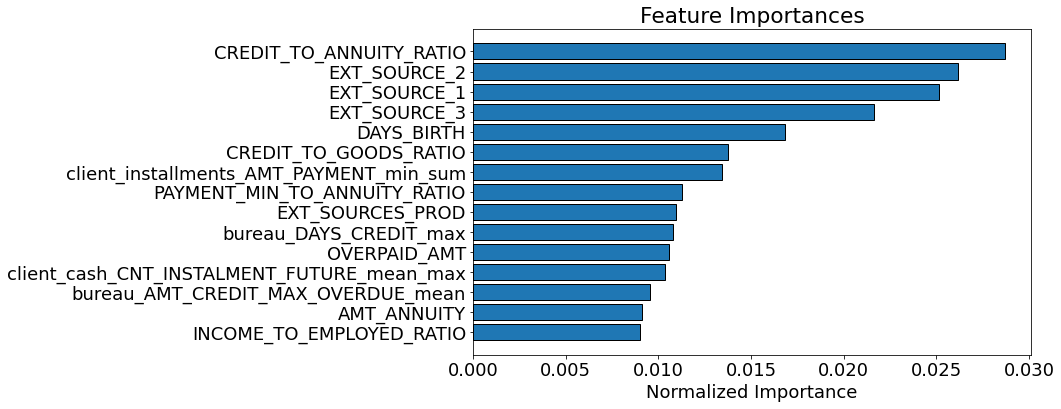

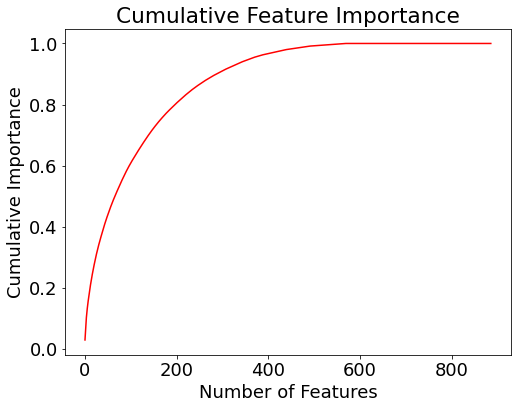

288 features required for 0.90 of cumulative importance


In [14]:
norm_feature_importances = plot_feature_importances(feature_importances)

In [15]:
#Let's remove the features that have zero importance.
train = train.drop(columns = zero_features)
test = test.drop(columns = zero_features)

print('Training shape: ', train.shape)
print('Testing shape: ', test.shape)

Training shape:  (307511, 567)
Testing shape:  (48744, 567)


## Checking again for the zero importance features

In [16]:
def identify_zero_importance_features(train, train_labels, iterations = 2):
    # Initialize an empty array to hold feature importances
    feature_importances = np.zeros(train.shape[1])

    # Create the model with several hyperparameters
    model = lgb.LGBMClassifier(objective='binary', boosting_type = 'goss', n_estimators = 10000, class_weight = 'balanced')
    
    # Fit the model multiple times to avoid overfitting
    for i in range(iterations):

        # Split into training and validation set
        train_features, valid_features, train_y, valid_y = train_test_split(train, train_labels, test_size = 0.25, random_state = i)

        # Train using early stopping
        model.fit(train_features, train_y, early_stopping_rounds=100, eval_set = [(valid_features, valid_y)], 
                  eval_metric = 'auc', verbose = 200)

        # Record the feature importances
        feature_importances += model.feature_importances_ / iterations
    
    feature_importances = pd.DataFrame({'feature': list(train.columns), 'importance': feature_importances}).sort_values('importance', ascending = False)
    
    # Find the features with zero importance
    zero_features = list(feature_importances[feature_importances['importance'] == 0.0]['feature'])
    print('\nThere are %d features with 0.0 importance' % len(zero_features))
    
    return zero_features, feature_importances

In [17]:
second_round_zero_features, feature_importances = identify_zero_importance_features(train, train_labels)

[200]	valid_0's auc: 0.786998	valid_0's binary_logloss: 0.502937
[200]	valid_0's auc: 0.787448	valid_0's binary_logloss: 0.503019

There are 0 features with 0.0 importance


In [18]:
zero_features = list(feature_importances[feature_importances['importance'] == 0.0]['feature'])
print('There are %d features with 0.0 importance' % len(zero_features))
feature_importances.tail()

There are 0 features with 0.0 importance


,feature,importance
365,client_credit_NAME_CONTRACT_STATUS_Signed_mean...,0.5
364,client_credit_AMT_INST_MIN_REGULARITY_min_sum,0.5
360,previous_CHANNEL_TYPE_Contactcenter_sum,0.5
348,previous_NAME_GOODS_CATEGORY_Medicine_mean,0.5
347,previous_CODE_REJECT_REASON_LIMIT_sum,0.5


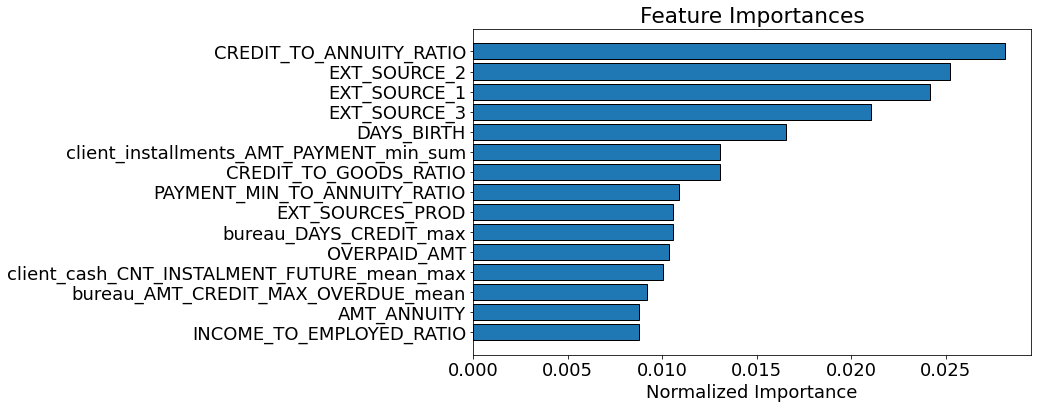

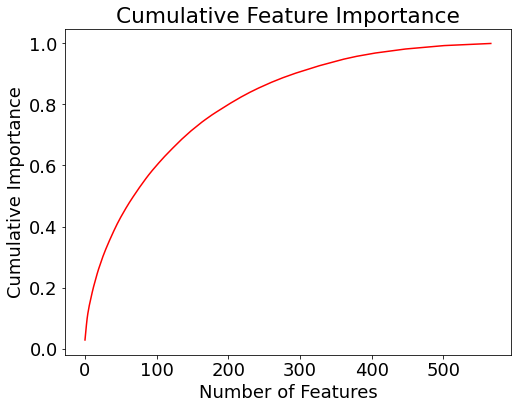

292 features required for 0.90 of cumulative importance


In [21]:
norm_feature_importances = plot_feature_importances(feature_importances, threshold = 0.9)

In [22]:
# Threshold for cumulative importance
threshold = 0.90

# Extract the features to keep
features_to_keep = list(norm_feature_importances[norm_feature_importances['cumulative_importance'] < threshold]['feature'])

# Create new datasets with smaller features
train_feature_imp = train[features_to_keep]
test_feature_imp = test[features_to_keep]

In [23]:
train_feature_imp['TARGET'] = train_labels
train_feature_imp['SK_ID_CURR'] = train_ids
test_feature_imp['SK_ID_CURR'] = test_ids

In [24]:
train_feature_imp.to_csv('train_feature_imp.csv', index = False)
test_feature_imp.to_csv('test_feature_imp.csv', index = False)